In [230]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [180]:
#--- Getting feature importances- only for pipeline
def get_imports(pipe, transformer, estimator, imports):
    '''
    takes a pipeline, it's named estimator, and # of important features
    
    
    Args:
        pipe: name of pipeline instance
        transformer (str): ex 'countvectorizer'
        estimator (str): ex. 'logisticregression', 'ridge'
        imports (int): number of important features desired
        
        
    '''
    features = pipe.named_steps[transformer].get_feature_names()
    coefs = pipe.named_steps[estimator].coef_
    coefs_df = pd.DataFrame({'importance': coefs[0]}, index = features)
    
    return coefs_df.sort_values('importance', ascending=False).head(imports)
    

#---Print train/test scores
def print_scores(model):
    print('train score: ' + str(model.score(X_train, y_train)))
    print('test score: ' + str(model.score(X_test, y_test)))

def print_scores_lem(model):
    print('train score: ' + str(model.score(X_train_lem, y_train_lem)))
    print('test score: ' + str(model.score(X_test_lem, y_test_lem)))    

In [199]:
posts = pd.read_csv('./data/clean_posts.csv')
posts.reset_index(drop=True, inplace=True)
posts.dropna(subset=['lemmatized'], inplace=True)

In [69]:
posts.index

RangeIndex(start=0, stop=19288, step=1)

In [67]:
covid.index

RangeIndex(start=0, stop=5716, step=1)

In [68]:
pre_covid.index

RangeIndex(start=0, stop=13572, step=1)

## Baseline Accuracy: 54.3%

In [182]:
posts['subreddit'].value_counts(normalize=True)

TalesFromYourServer    0.543032
TalesFromRetail        0.456968
Name: subreddit, dtype: float64

## TTS for lemmatized and non-lemmatized

Positive class: TalesFromYourServer

In [200]:
X_lem = posts['lemmatized']

X = posts['selftext']
y = np.where(posts['subreddit'] == 'TalesFromYourServer', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y)

In [201]:
X_train_lem.isna().sum()

0

## First Model: Simple Logistic Regression w/ Count Vectorizer

In [202]:
logr = LogisticRegression(max_iter=1000, n_jobs=-1)
ss = StandardScaler(with_mean=False)
cvect = CountVectorizer()

pipe = make_pipeline(cvect, ss, logr)

pipe.fit(X_train, y_train)
print_scores(pipe)

train score: 0.9998617065412806
test score: 0.9151628292885293


In [203]:
pipe.fit(X_train_lem, y_train_lem)
print_scores_lem(pipe)

train score: 0.9999308532706404
test score: 0.9101846090022817


In [185]:
get_imports(pipe, 'countvectorizer', 'logisticregression', 10)

,importance
restaurant,0.702886
tip,0.464955
server,0.445985
table,0.422824
servers,0.310700
tables,0.301698
food,0.298683
tips,0.290433
serving,0.277777
restaurants,0.276274


## Logistic Regression with some hyperparameter tuning:

In [204]:
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
ss = StandardScaler(with_mean=False)
cvect_logreg = CountVectorizer(stop_words='english', max_features=500) 
tfidf_logreg = TfidfVectorizer(stop_words='english', max_features=500)


pipe_logreg_cvect = make_pipeline(cvect_logreg, ss, logreg)
pipe_logreg_tfidf = make_pipeline(tfidf_logreg, ss, logreg)

pipe_logreg_cvect.fit(X_train, y_train)
print_scores(pipe_logreg_cvect)

train score: 0.9551237726455538
test score: 0.9450321510060153


In [205]:
pipe_logreg_cvect.fit(X_train_lem, y_train_lem)
print('Cvect:')
print_scores_lem(pipe_logreg_cvect)

pipe_logreg_tfidf.fit(X_train_lem, y_train_lem)
print('TFIDF:')
print_scores_lem(pipe_logreg_tfidf)

Cvect:
train score: 0.958097082008021
test score: 0.940261356565028
TFIDF:
train score: 0.9596874567832941
test score: 0.9439950217797137


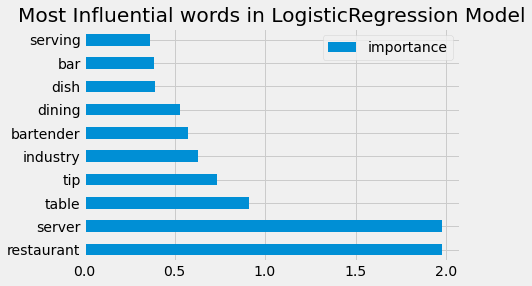

In [206]:
get_imports(pipe_logreg_tfidf, 'tfidfvectorizer', 'logisticregression', 10).plot(kind='barh')
plt.title('Most Influential words in LogisticRegression Model');

## Naive Bayes

In [207]:
cvect4 = CountVectorizer(stop_words='english', max_features=500) #--Overfit without max_features
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
ss = StandardScaler(with_mean=False)
nb = MultinomialNB()

pipe_nb_cvect = make_pipeline(cvect4, ss, nb)
pipe_nb_tfidf = make_pipeline(tfidf, ss, nb)


pipe_nb_cvect.fit(X_train, y_train)
pipe_nb_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=500, stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('multinomialnb', MultinomialNB())])

In [208]:
#---Not a huge difference in performance with Cvect vs Tfidf

print('NB with CVect:')
print_scores(pipe_nb_cvect)
print(' ')
print('NB with TfIdf')
print_scores(pipe_nb_tfidf)

NB with CVect:
train score: 0.9343797538376435
test score: 0.9369425430408629
 
NB with TfIdf
train score: 0.9311298575577375
test score: 0.9309271935283137


In [209]:
pipe_nb_cvect.fit(X_train_lem, y_train_lem)
pipe_nb_tfidf.fit(X_train_lem, y_train_lem)

print('NB with CVect:')
print_scores_lem(pipe_nb_cvect)
print(' ')
print('NB with TfIdf')
print_scores_lem(pipe_nb_tfidf)

NB with CVect:
train score: 0.9365924491771539
test score: 0.9336237295166978
 
NB with TfIdf
train score: 0.9301618033467017
test score: 0.9276083800041485


In [20]:
get_imports(pipe_nb_cvect, 'countvectorizer', 'multinomialnb', 10) #-- not as easy to interpret

,coefs
restaurant,-4.976109
table,-5.005157
like,-5.011137
time,-5.075603
server,-5.114036
work,-5.120578
people,-5.168382
know,-5.193314
make,-5.270377
food,-5.292627


## RandomForest

In [220]:
cvect_forest = CountVectorizer(stop_words='english', max_features=500)
tfidf_forest = TfidfVectorizer(stop_words='english', max_features=500)
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1)

pipe_forest_cvect = make_pipeline(cvect_forest, ss, forest)
pipe_forest_tfidf = make_pipeline(tfidf_forest, ss, forest)

pipe_forest_cvect.fit(X_train_lem, y_train_lem)
print_scores_lem(pipe_forest_cvect)

train score: 0.9995159728944821
test score: 0.9541588881974694


In [221]:
pipe_forest_tfidf.fit(X_train_lem, y_train_lem)
print_scores_lem(pipe_forest_tfidf)

train score: 0.9995159728944821
test score: 0.9570628500311139


## SVC

In [72]:
cvect_svc = CountVectorizer(stop_words='english', max_features=500)
tfidf_svc = TfidfVectorizer(stop_words='english', max_features=500)
svc = SVC()

pipe_svc_cvect = make_pipeline(cvect_svc, ss, svc)
pipe_svc_tfidf = make_pipeline(tfidf_svc, ss, svc)

pipe_svc_cvect.fit(X_train_lem, y_train_lem)
print_scores_lem(pipe_svc_cvect)

train score: 0.9738697635835752
test score: 0.9413106594773952


In [73]:
pipe_svc_tfidf.fit(X_train_lem, y_train_lem)
print_scores_lem(pipe_svc_tfidf)

train score: 0.9871422646204894
test score: 0.9454583160514309


# Boosting

#### AdaBoost

In [70]:
cvect_boost = CountVectorizer(stop_words='english', max_features=500)
tfidf_boost = TfidfVectorizer(stop_words='english', max_features=500)

adaboost = AdaBoostClassifier(n_estimators = 100)

pipe_boost_cvect = make_pipeline(cvect_boost, ss, adaboost)
pipe_boost_tfidf = make_pipeline(tfidf_boost, ss, adaboost)

pipe_boost_cvect.fit(X_train_lem, y_train_lem)
pipe_boost_tfidf.fit(X_train_lem, y_train_lem)

print('AdaBoost with CVect')
print_scores_lem(pipe_boost_cvect)
print()
print('Adaboost with TFIDF')
print_scores_lem(pipe_boost_tfidf)

AdaBoost with CVect
train score: 0.9454583160514309
test score: 0.9334301119867275

Adaboost with TFIDF
train score: 0.954997926171713
test score: 0.9437992534218167


#### GradientBoost

In [71]:
gboost = GradientBoostingClassifier(n_estimators=100)

pipe_gboost_cvect = make_pipeline(cvect_boost, ss, gboost)
pipe_gboost_tfidf = make_pipeline(tfidf_boost, ss, gboost)

pipe_gboost_cvect.fit(X_train_lem, y_train_lem)
pipe_gboost_tfidf.fit(X_train_lem, y_train_lem)

print('GradBoost with CVect')
print_scores_lem(pipe_gboost_cvect)
print()
print('Gradboost with TFIDF')
print_scores_lem(pipe_gboost_tfidf)

GradBoost with CVect
train score: 0.9107562560486658
test score: 0.9021153048527581

Gradboost with TFIDF
train score: 0.9535462463708005
test score: 0.9419328079635007


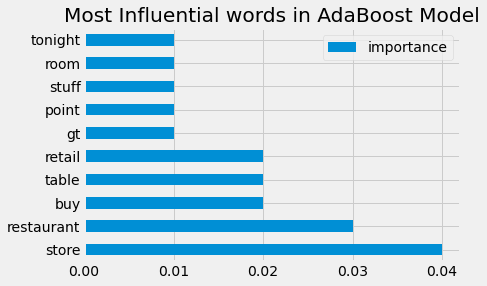

In [175]:
features = pipe_boost_tfidf.named_steps.tfidfvectorizer.get_feature_names()
imports = pipe_boost_tfidf.named_steps.adaboostclassifier.feature_importances_
pd.DataFrame({'importance': imports}, index = features).sort_values('importance', ascending=False).head(10).plot(kind='barh')
plt.title('Most Influential words in AdaBoost Model');

## GridSearch AdaBoost, SVC, and LogisticRegression with TFIDF

In [ ]:
#---Adaboost Grid

In [85]:
tfidf = TfidfVectorizer(stop_words='english')
ss = StandardScaler(with_mean=False)
boost = AdaBoostClassifier()

pipe = make_pipeline(tfidf, ss, boost)

params = {
    'tfidfvectorizer__ngram_range' : [(1,1), (1,2), (2,2)],
    'adaboostclassifier__n_estimators' : [50, 100, 200],
    'adaboostclassifier__learning_rate' : [1, 2, 5]
}

grid_boost = GridSearchCV(pipe, params, n_jobs=-1)

In [86]:
grid_boost.fit(X_train_lem, y_train_lem)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'adaboostclassifier__learning_rate': [1, 2, 5],
                         'adaboostclassifier__n_estimators': [50, 100, 200],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2)]})

In [87]:
print_scores_lem(grid_boost)

train score: 0.968754320475598
test score: 0.9483616756532559


In [88]:
grid_boost.best_params_

{'adaboostclassifier__learning_rate': 1,
 'adaboostclassifier__n_estimators': 200,
 'tfidfvectorizer__ngram_range': (1, 2)}

In [176]:
#---SVC GridSearch. Too long to fit. 

tfidf = TfidfVectorizer(stop_words='english')
ss = StandardScaler(with_mean=False)
svc = SVC()

pipe = make_pipeline(tfidf, ss, svc)

params = {
    'tfidfvectorizer__ngram_range' : [(1,1), (1,2)],
    'svc__C' : [1, 10, 50],
    'svc__kernel' : ['rbf', 'sigmoid']
}

grid_svc = GridSearchCV(pipe, params, n_jobs=-1)

In [177]:
grid_svc.fit(X_train_lem, y_train_lem)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 10, 50],
                         'svc__kernel': ['rbf', 'sigmoid'],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
print_scores_lem(grid_svc)

train score: 0.9994469791234619
test score: 0.9164247200331812


In [57]:
tfidf_logreg = TfidfVectorizer(stop_words='english')
ss = StandardScaler(with_mean=False)
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)

pipe_logreg_tfidf = make_pipeline(tfidf_logreg, ss, logreg)

params = {
    'tfidfvectorizer__max_features' : [200, 500, 1000],
    'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__C' : [.0001, .001, .1, 1, 10, 100]
}

grid_log = GridSearchCV(pipe_logreg_tfidf, params, n_jobs=-1)
grid_log.fit(X_train_lem, y_train_lem)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.1, 1, 10,
                                                   100],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'tfidfvectorizer__max_features': [200, 500, 1000]})

In [58]:
grid_log.best_params_

{'logisticregression__C': 0.001,
 'logisticregression__penalty': 'l2',
 'tfidfvectorizer__max_features': 1000}

In [59]:
print_scores_lem(grid_log)

train score: 0.9577630305544035
test score: 0.947324761509747


# My best model, for future use:

In [229]:
#---Custom Lemmatizer repurposed for use in pipeline

def custom_lemmatize(text):
    
    
    #instantiate Lemmatizer and new dictionary to house altered posts
    lemmatizer = WordNetLemmatizer()
    
    #setting up list of stopwords
    stops = stopwords.words('english')
         
    text = text.lower()

    #stripping the post of non-letters and frequently occuring TLDR; expression ('too long don't read)
    exclusion_list = ['[^a-zA-Z]', 'tldr', 'tl;dr', 'http', '.com', 'www']
    exclusions = '|'.join(exclusion_list)
    text = re.sub(exclusions, ' ' , text)
        
    #---Lemmatizing words, preserving stopwords for transformer to handle
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stops]
        
    #---Adding lemmatized post to dictionary
    return ' '.join(words)
        
        
tfidf_forest = TfidfVectorizer(tokenizer=custom_lemmatize, stop_words='english', max_features=500)
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1)

pipeline = make_pipeline(tfidf_forest, ss, forest)        

# COVID Exploration

In [125]:
covid = pd.read_csv('./data/covid.csv', index_col=0)
pre_covid = pd.read_csv('./data/pre_covid.csv', index_col=0)

covid.dropna(axis=0, subset=['lemmatized'], inplace=True)
pre_covid.dropna(axis=0, subset=['lemmatized'], inplace=True)

In [127]:
X_cov = covid['lemmatized']
y_cov = covid['subreddit']

X_pre = pre_covid['lemmatized']
y_pre = pre_covid['subreddit']

X_train_cov, X_test_cov, y_train_cov, y_test_cov = train_test_split(X_cov, y_cov)
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_pre, y_pre)

### AdaBoost

In [157]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=500)
ss = StandardScaler(with_mean=False)
boost = AdaBoostClassifier(n_estimators=200, )

pipe = make_pipeline(tfidf, ss, boost)

In [152]:
pipe.fit(X_train_pre, y_train_pre)
print('AdaBoost Pre Covid')
print('train: ' + str(pipe.score(X_train_pre, y_train_pre)))
print('test: ' + str(pipe.score(X_test_pre, y_test_pre)))

AdaBoost Pre Covid
train: 0.9637382075471698
test: 0.9436910377358491


In [153]:
pipe.fit(X_train_cov, y_train_cov)
print('AdaBoost During Covid')
print('train: ' + str(pipe.score(X_train_cov, y_train_cov)))
print('test: ' + str(pipe.score(X_test_cov, y_test_cov)))

AdaBoost During Covid
train: 0.9997666822211853
test: 0.9580125962211337


In [158]:
pipe.fit(X_pre, y_pre)

print('score on Covid data: ' + str(pipe.score(X_cov, y_cov)))

score on Covid data: 0.941907261592301


### LogisticRegression

In [145]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
ss = StandardScaler(with_mean=False)
logreg = LogisticRegression(C=.001, max_iter=1000, n_jobs=-1)
log = LogisticRegression()

pipe = make_pipeline(tfidf, ss, logreg)



In [154]:
pipe.fit(X_train_pre, y_train_pre)
print('LogReg Pre Covid')
print('train: ' + str(pipe.score(X_train_pre, y_train_pre)))
print('test: ' + str(pipe.score(X_test_pre, y_test_pre)))

LogReg Pre Covid
train: 0.9637382075471698
test: 0.9436910377358491

score on Covid data: 0.9359580052493438


In [147]:
pipe.fit(X_train_cov, y_train_cov)
print('LogReg During Covid')
print('train: ' + str(pipe.score(X_train_cov, y_train_cov)))
print('test: ' + str(pipe.score(X_test_cov, y_test_cov)))

LogReg During Covid
train: 0.9636024265048997
test: 0.940517844646606


In [155]:
pipe.fit(X_train_pre, y_train_pre)

print('score on Covid data: ' + str(pipe.score(X_cov, y_cov)))

score on Covid data: 0.9359580052493438


### RandomForest

In [222]:
#---using pipeline from above

pipe_forest_tfidf.fit(X_train_pre, y_train_pre)
print('RandomForest Pre Covid')
print('train: ' + str(pipe_forest_tfidf.score(X_train_pre, y_train_pre)))
print('test: ' + str(pipe_forest_tfidf.score(X_test_pre, y_test_pre)))

RandomForest Pre Covid
train: 0.9996069182389937
test: 0.9522405660377359


In [223]:
print('score on Covid data: ' + str(pipe_forest_tfidf.score(X_cov, y_cov)))

score on Covid data: 0.9464566929133859
